# Image Classification

## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from PIL import Image
import io

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [28]:
print(tf.__version__)

2.17.0


In [57]:
print("Devices available: ", tf.config.list_physical_devices())
print("GPUs available: ", tf.config.list_physical_devices('GPU'))
print("Is TensorFlow using GPU? ", tf.test.is_gpu_available())

Devices available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs available:  []
Is TensorFlow using GPU?  False


In [3]:
!pip freeze > requirements.txt

## Data Path Preparation

### Create Path

In [108]:
main_dir = 'Dataset'

In [109]:
if os.path.exists(main_dir):
    for subdir_name in os.listdir(main_dir):
        subdir_path = os.path.join(main_dir, subdir_name)

        if os.path.isdir(subdir_path):
            print(f'Memproses subdir: {subdir_path}')           

Memproses subdir: Dataset\cardboard
Memproses subdir: Dataset\e-waste
Memproses subdir: Dataset\glass
Memproses subdir: Dataset\medical
Memproses subdir: Dataset\metal
Memproses subdir: Dataset\paper
Memproses subdir: Dataset\plastic


In [110]:
data_paths = []
labels = []

class_list = os.listdir(main_dir)

for classes in class_list:
    class_path = os.path.join(main_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for file in file_list:
            f_path = os.path.join(class_path, file)
            data_paths.append(f_path)
            labels.append(classes)

In [111]:
# Path Checking

F_series = pd.Series(data_paths, name='file_paths')
L_series = pd.Series(labels, name='labels')

data_df = pd.concat([F_series, L_series], axis=1)

print(data_df.head())
print(data_df['labels'].value_counts())

                             file_paths     labels
0     Dataset\cardboard\cardboard 1.jpg  cardboard
1    Dataset\cardboard\cardboard 10.jpg  cardboard
2   Dataset\cardboard\cardboard 100.jpg  cardboard
3  Dataset\cardboard\cardboard 1000.jpg  cardboard
4  Dataset\cardboard\cardboard 1001.jpg  cardboard
labels
e-waste      2405
paper        2156
plastic      2126
metal        2068
glass        2022
cardboard    1931
medical      1565
Name: count, dtype: int64


### Image Validation

In [112]:
def is_valid_image(filepath):
    try:
        img = Image.open(filepath)
        img.verify()  # Verifikasi gambar tanpa membacanya sepenuhnya
        return True
    except (IOError, SyntaxError) as e:
        return False

def check_images_in_directory(directory):
    invalid_images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if not is_valid_image(filepath):
            invalid_images.append(filepath)
    return invalid_images

In [113]:
invalid_images = check_images_in_directory(subdir_path)

In [114]:
if invalid_images:
    print(f"Found {len(invalid_images)} invalid images:")
    for img in invalid_images:
        print(img)
else:
    print("All images are valid.")

All images are valid.


## Data Split

In [115]:
train_size = 0.8 
test_size = 0.2

In [116]:
train_set, test_set = train_test_split(data_df, test_size=test_size, shuffle=True, stratify=data_df['labels'], random_state=42)

print('train_set length:', len(train_set), 'test_set length:', len(test_set))


train_set length: 11418 test_set length: 2855


## Preprocessing

### Standarisasi

In [117]:
def get_image_size(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"Error opening image {filepath}: {e}")
        return None

def find_smallest_image(directory):
    smallest_image = None
    smallest_size = None

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        size = get_image_size(filepath)
        
        if size:
            if smallest_size is None or (size[0] * size[1] < smallest_size[0] * smallest_size[1]):
                smallest_size = size
                smallest_image = filepath
    
    return smallest_image, smallest_size

In [118]:
smallest_image, smallest_size = find_smallest_image(subdir_path)

if smallest_image:
    print(f"The smallest image is {smallest_image} with size {smallest_size}")
else:
    print("No valid images found.")

The smallest image is Dataset\plastic\plastic 1992.jpg with size (125, 125)


In [119]:
# Standarisasi Data
height = 125
width = 125
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

### Augmentation

In [120]:
train_datagen = ImageDataGenerator(
    rescale= 1./255.,
    rotation_range= 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode= 'nearest'
)

In [121]:
# Train Data
train_gen = train_datagen.flow_from_dataframe(train_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 11418 validated image filenames belonging to 7 classes.


In [122]:
test_datagen = ImageDataGenerator(
    rescale= 1./255.
)

In [123]:
# Test Data
test_gen = test_datagen.flow_from_dataframe(test_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 2855 validated image filenames belonging to 7 classes.


In [124]:
train_categories = list(train_gen.class_indices.keys())
print(train_categories)

['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


## Data Checking

In [125]:
def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize= (20, 20))
    for i in range(min(len(labels), 20)):
        plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = train_categories[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

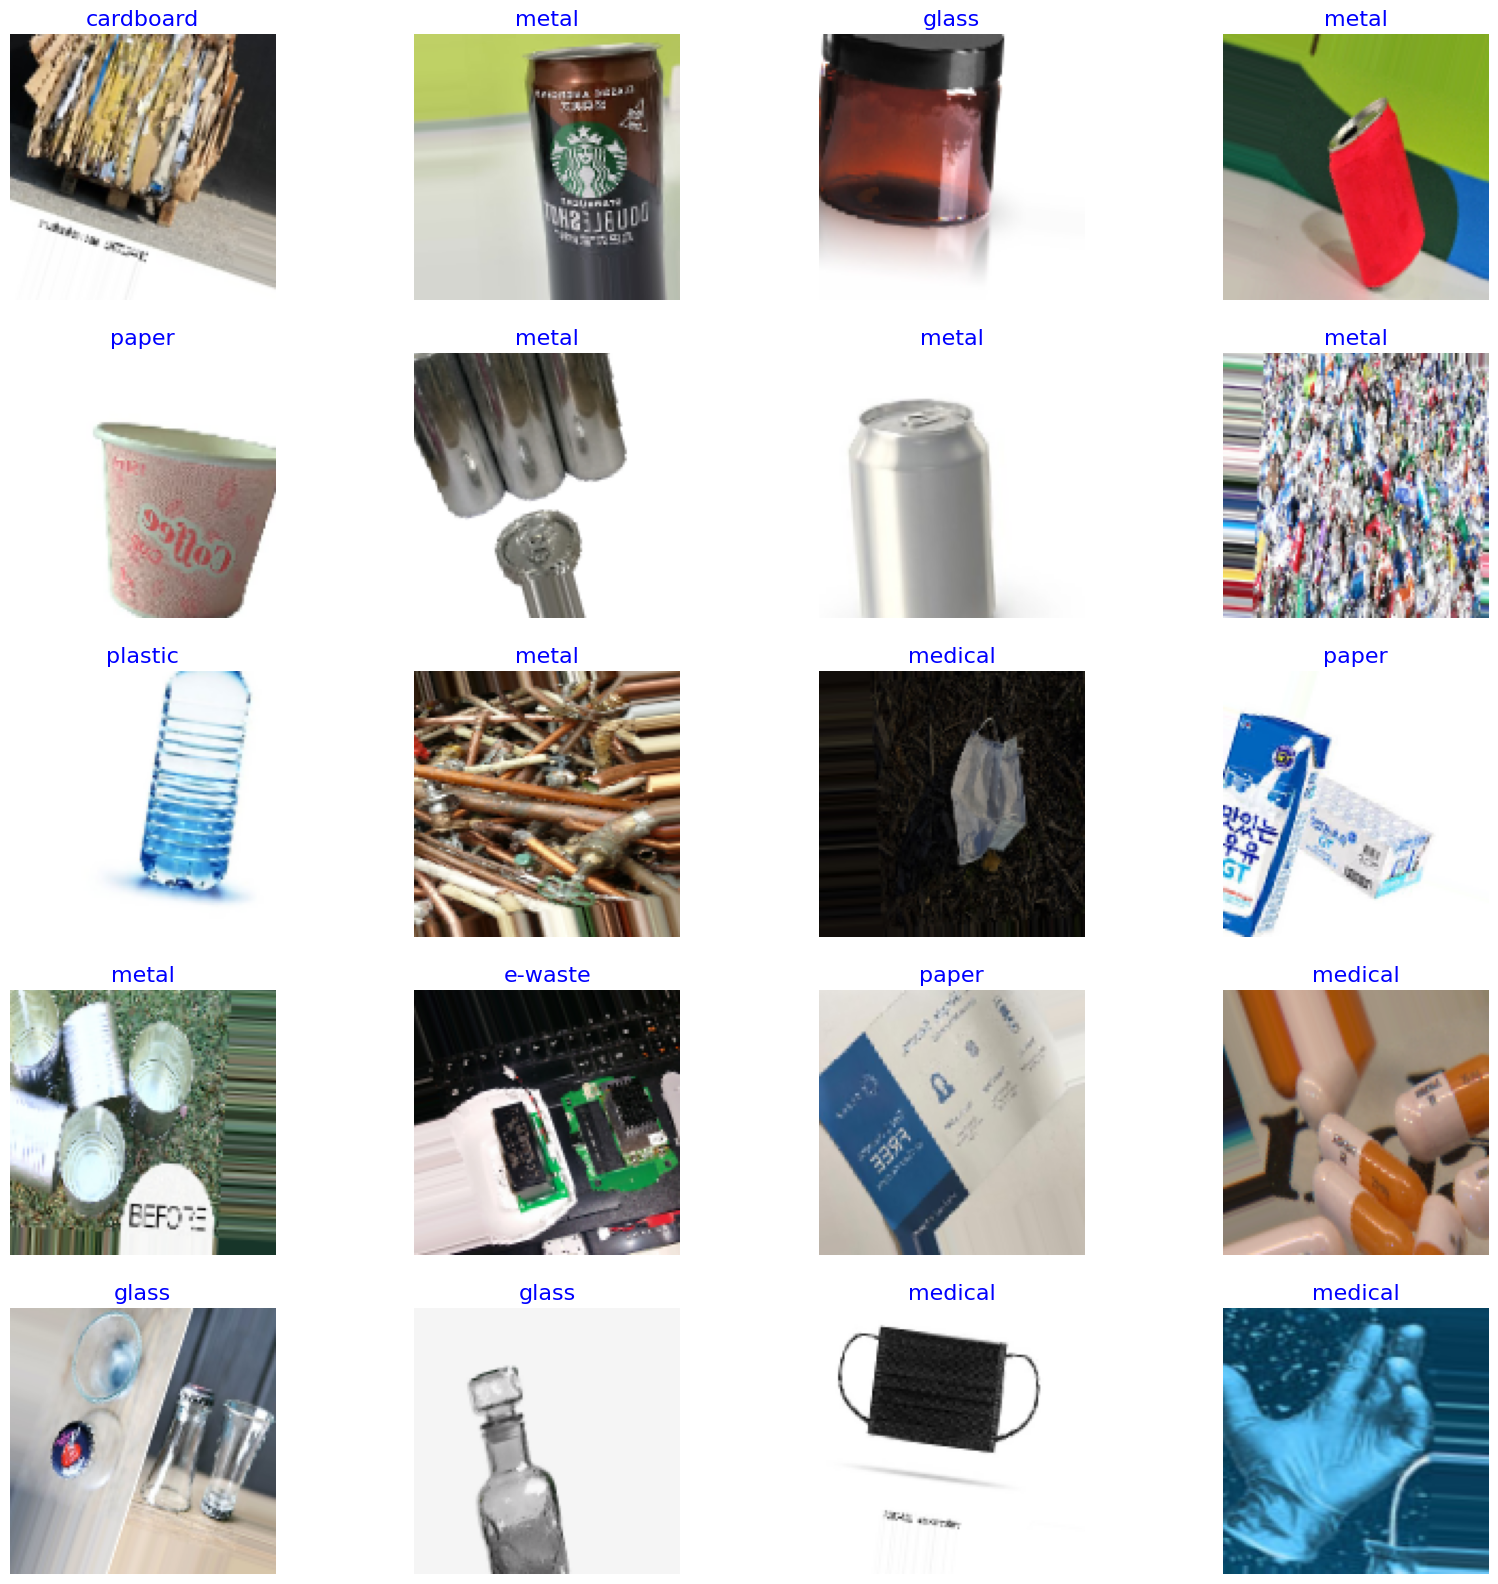

In [126]:
show_samples(train_gen)

## Model

### Design

In [127]:
from tensorflow.keras.applications import ResNet50

In [128]:
num_classes = len(classes)

base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape)
base_model.trainable = False

In [129]:
model = Sequential([
    base_model,
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    GlobalAveragePooling2D(),
    Dropout(rate=0.5),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Build the model
model.build((None, *img_shape))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,196,903 (92.30 MB)

 Trainable params: 608,999 (2.32 MB)

 Non-trainable params: 23,587,904 (89.98 MB)

### Training

In [130]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [131]:
history = model.fit(train_gen, 
                    epochs=20, 
                    validation_data=test_gen,
                    steps_per_epoch=len(train_set) // 1024,
                    validation_steps=len(test_set) // 1024, 
                    callbacks=[early_stopping, checkpoint],
)

Epoch 1/20


c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 9/11 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.1279 - loss: 2.8014

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000161AD7FF1D0>
Traceback (most recent call last):

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    return "pyfunc_%d" % uid

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    def wrapper(*args, **kwargs):

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 260, in _get_iterator
    for i, batch in enumerate(gen_fn()):

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 253, in generator_fn
    yield self.py_dataset[i]

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\keras\src\legacy\preprocessing\image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\keras\src\utils\image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "c:\Users\ACER\.conda\envs\Tensorflow-GPU\lib\site-packages\PIL\Image.py", line 3498, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000161AD7FF1D0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_52916]

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Save Model

### TF-Lite

### TFJS

### TF-Serving